In [ ]:
import pandas as pd

df = pd.read_csv("transactions.csv")

# Binary label: suspicious or STR filed
df["is_suspicious"] = (
    df["suspicion_determined_datetime"].notna() | df["str_filed_datetime"].notna()
).astype(int)

In [87]:
drop_cols = [
    "transaction_id",
    "customer_id",
    "risk_reasoning",
    "booking_datetime",
    "value_date",
    "narrative",
    "originator_name",
    "originator_account",
    "beneficiary_name",
    "beneficiary_account",
    "originator_country",
    "beneficiary_country",
    "suspicion_determined_datetime",
    "str_filed_datetime"
]
df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")


In [88]:
from sklearn.preprocessing import LabelEncoder

cat_cols = df.select_dtypes(include=["object"]).columns
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le


In [89]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["is_suspicious"])
y = df["is_suspicious"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [90]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report

model = XGBClassifier(
    eval_metric="logloss",
    learning_rate=0.1,
    max_depth=6,
    n_estimators=300,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)

y_prob = model.predict_proba(X_test)[:, 1]
y_pred = (y_prob > 0.7).astype(int)  # 0.7 = suspicion threshold


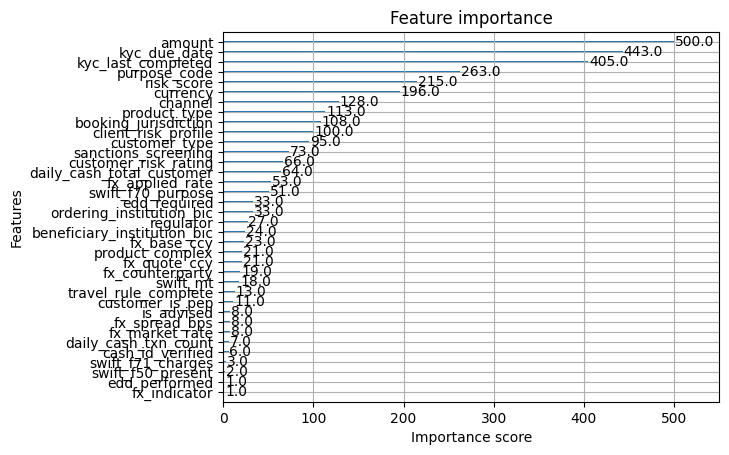

In [92]:
from matplotlib import pyplot as plt
from xgboost import plot_importance
plot_importance(model)
plt.show()

In [93]:
print(classification_report(y_test, y_pred))
auc = roc_auc_score(y_test, y_prob)
print(f"AUC: {auc:.3f}")

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       185
           1       0.00      0.00      0.00        15

    accuracy                           0.93       200
   macro avg       0.46      0.50      0.48       200
weighted avg       0.86      0.93      0.89       200

AUC: 0.444


/Users/jaytai/Documents/Hackathon/lexi_backend/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/jaytai/Documents/Hackathon/lexi_backend/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/jaytai/Documents/Hackathon/lexi_backend/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control thi

In [95]:
df["suspicion_confidence"] = model.predict_proba(X)[:, 1]
df["flagged"] = (df["suspicion_confidence"] > 0.7).astype(int)

df.to_csv("transactions_with_suspicion_score.csv", index=False)
